In [9]:
import librosa
import pandas as pd
import numpy as np
import os
import wave
# from ..audio_handler import DemoAudioHandler
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
import joblib
%matplotlib inline

# Feature Extracttion

In [16]:
def loadfile(fname):
    with wave.open(fname, 'rb') as wf:
        # print(wf.getnchannels())
        # print(wf.getframerate())
        # print(wf.getparams())
        frames = wf.readframes(wf.getnframes())
        # print(len(frames))
        # print(frames)
        audio_data = frames
        audio_array = np.frombuffer(audio_data, dtype=np.int16)
        return audio_array
        
def extract_mfccs(audio_file_path):
    n_mfcc = 10
    audio_array = loadfile(audio_file_path)
    mfccs = librosa.feature.mfcc(y=audio_array.astype('float32'), 
                              sr=44100, n_mfcc=10,dtype=np.float32)
    # y, sr = librosa.load(audio_file_path)
    # mfccs = librosa.feature.mfcc(y=y, sr=8000, n_mfcc=n_mfcc)
    return mfccs.mean(axis=1) 

def extract_mfccs_proper(audio_file_path):
    n_mfcc = 10
    y, sr = librosa.load(audio_file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=44100, n_mfcc=n_mfcc)
    return mfccs.mean(axis=1) 

In [18]:
# too lazy to figure out how to elimininate index without IO
esccsv = "./data/esc_50/meta/esc50.csv" 
escmeta = pd.read_csv(esccsv) 

clean_esc50 = escmeta[escmeta['category'] != "crying_baby"].filter(['filename'],axis=1)
clean_esc50.insert(1,'classification','negative')
clean_esc50.to_csv('intermediate.csv', index=False)
clean_esc50 = pd.read_csv('intermediate.csv')

cry_esc50 = escmeta[escmeta['category'] == "crying_baby"].filter(['filename'],axis=1)
cry_esc50.insert(1,'classification','positive')
cry_esc50.to_csv('intermediate.csv', index=False)
cry_esc50 = pd.read_csv('intermediate.csv')

## Dataframes for pos and negative

In [19]:
cry_data_path = "./data/donateacry_cleaned"
cry_categories = os.listdir(cry_data_path)
cry_categories = [cat for cat in cry_categories if cat != 'README.md']

In [21]:
cries_list = np.array([[fname,category] for category in cry_categories for fname in os.listdir(cry_data_path + "/" + category)]) 
cries = pd.DataFrame(cries_list, columns = ['filename', 'classification'])
cries_det = cries.assign(classification='positive')
cries_det.head()

,filename,classification
0,10A40438-09AA-4A21-83B4-8119F03F7A11-143092514...,positive
1,d6cda191-4962-4308-9a36-46d5648a95ed-143108626...,positive
2,7b0e160e-0505-459e-8ecb-304d7afae9d2-143748697...,positive
3,1309B82C-F146-46F0-A723-45345AFA6EA8-143280169...,positive
4,999bf14b-e417-4b44-b746-9253f81efe38-143084501...,positive


In [22]:
neg_set = clean_esc50
pos_set = cries_det

In [24]:
# it's quite hacky but will need to have different mfccs for training and for showing
# this is due to how the live data needs to be streamed in int16 even though the training data is stored
# in float32 -> for the live data even though the mfccs are wrong, the outputs are deterministic meaning
# we still have correct classifiction if we load the training data in the same, incorrect, way

# to avoid this would require some deeper debugging and still would not garruentee we can fix it without 
# a higher quality mic or without some sort of preproccessing

#TLDR: bug as a feature
demo_detection_labels = pd.concat([neg_set,pos_set])
live_detection_labels = pd.concat([neg_set,pos_set])

## Extracting MFCCs

In [25]:
audio_files = []
# cry_esc50_data_path = "./data/esc_50/audio"
# cry_esc50_audio_files = np.array([f"{cry_esc50_data_path}/{fname}" for fname in cry_esc50['filename']])
# audio_files.extend(cry_esc50_audio_files)

neg_data_path = "./data/esc_50/audio"
neg_audio_files = np.array([f"{neg_data_path}/{fname}" for fname in clean_esc50['filename']]) 
audio_files.extend(neg_audio_files)

cry_data_path = "./data/donateacry_cleaned"
cry_categories = [cat for cat in os.listdir(cry_data_path) if cat != 'README.md']
cry_audio_files = np.array([f"{cry_data_path}/{category}/{fname}" for category in cry_categories for fname in os.listdir(cry_data_path + "/" + category)]) 
audio_files.extend(cry_audio_files)

In [26]:
print(len(audio_files))
print(audio_files[-1])

2417
./data/donateacry_cleaned/hungry/aaa57dbd-7b88-454a-963e-6faa2f4ed4e7-1436910225455-1.7-f-04-hu.wav


In [28]:
%%time
mfcc_vectors = []

# Extract MFCC vectors for each audio file and store them in the list
for audio_file_path in audio_files:
    mfcc_vector = extract_mfccs_proper(audio_file_path)
    mfcc_vectors.append(mfcc_vector)

CPU times: user 14min 42s, sys: 3.61 s, total: 14min 45s
Wall time: 7min 3s


In [11]:
n_mfcc = 10
mfcc_df = pd.DataFrame(data=mfcc_vectors, columns=[f'MFCC_{i}' for i in range(1, n_mfcc + 1)])
mfcc_df.head()

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,-564.442139,8.385604,-2.276850,-4.512311,-2.347291,-1.745333,-1.814555,-1.086150,-1.880887,-0.313914
1,-142.999680,37.181145,-56.660969,8.878623,-15.041111,11.346839,-31.963560,-17.786943,-11.256812,-13.532288
2,42.051224,60.085186,-7.855661,26.267555,-5.396732,3.353272,1.614957,3.357804,-16.075333,19.716097
3,43.779510,57.934246,-5.346288,23.884005,-4.785521,2.999132,1.493073,2.765526,-13.170007,19.963636
4,-420.739258,95.851379,33.803692,51.674496,13.107634,26.776213,16.624161,11.390849,-10.480467,9.661076


In [18]:
demo_detection_set = pd.concat([demo_detection_labels.reset_index(drop=True)
                                ,mfcc_df],axis=1)

NameError: name 'mfcc_df' is not defined

In [48]:
live_mfcc_vectors = []

# Extract MFCC vectors for each audio file and store them in the list
for audio_file_path in audio_files:
    mfcc_vector = extract_mfccs(audio_file_path)
    live_mfcc_vectors.append(mfcc_vector)

In [49]:
n_mfcc = 10
live_mfcc_df = pd.DataFrame(data=live_mfcc_vectors, columns=[f'MFCC_{i}' for i in range(1, n_mfcc + 1)])
live_mfcc_df.head()

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,439.989624,8.207122,-6.658803,-4.290906,-3.034478,0.259279,-1.963946,-0.271577,0.518284,0.341884
1,766.793335,85.839622,-107.103157,31.011578,-39.987736,-17.290340,-37.214104,-18.145689,-11.705071,-17.621454
2,991.268494,102.503899,-40.419437,39.016899,-22.449158,12.773843,-8.455192,20.697041,-11.590557,18.945305
3,990.615356,104.300377,-43.018017,42.277382,-26.241453,18.346586,-10.591763,22.344328,-12.172708,16.495598
4,555.107544,144.261398,22.961348,52.213543,2.970680,11.319603,-2.895933,0.076407,-8.929121,10.019114


In [50]:
live_mfcc_df.tail()

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
2412,659.400574,100.399101,-43.210793,-44.191681,10.375557,-0.130803,-18.864626,0.781123,1.627277,-16.970087
2413,836.544312,141.567551,-51.287121,-27.726849,40.748886,1.321327,-34.718052,5.841194,14.296042,-17.967588
2414,688.141479,139.737564,-6.201358,-24.557714,11.159669,-9.196754,-34.802990,-19.102283,-12.335887,-23.200171
2415,614.463867,165.236099,-22.854877,-45.759483,11.059427,-4.174662,-39.150570,-16.890171,10.902433,4.265208
2416,516.097534,41.088757,2.261911,-2.188980,9.307535,5.938362,-0.914264,2.282546,2.996188,-3.348261


In [51]:
live_detection_set = pd.concat([live_detection_labels.reset_index(drop=True)
                                ,live_mfcc_df],axis=1)

In [52]:
live_detection_set.tail()

,filename,classification,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
2412,8f5c01dc-6826-4076-a831-027ad61afdaf-143587350...,positive,659.400574,100.399101,-43.210793,-44.191681,10.375557,-0.130803,-18.864626,0.781123,1.627277,-16.970087
2413,40a4c760-facf-4911-b0a6-22eccc3ab18d-143047771...,positive,836.544312,141.567551,-51.287121,-27.726849,40.748886,1.321327,-34.718052,5.841194,14.296042,-17.967588
2414,F24DE44B-762C-4149-AC92-96A5E57ED118-143081693...,positive,688.141479,139.737564,-6.201358,-24.557714,11.159669,-9.196754,-34.802990,-19.102283,-12.335887,-23.200171
2415,9aa8bac5-eeb9-4f19-a4bf-7c439e87364b-143074538...,positive,614.463867,165.236099,-22.854877,-45.759483,11.059427,-4.174662,-39.150570,-16.890171,10.902433,4.265208
2416,aaa57dbd-7b88-454a-963e-6faa2f4ed4e7-143691022...,positive,516.097534,41.088757,2.261911,-2.188980,9.307535,5.938362,-0.914264,2.282546,2.996188,-3.348261


In [18]:
demo_detection_set.to_csv('proper_detections_mfccs.csv', index=False)

In [53]:
live_detection_set.to_csv('live_detections_mfccs.csv', index=False)

# Cry Detection

In [54]:
demo_detection_set = pd.read_csv('proper_detections_mfccs.csv')
live_detection_set = pd.read_csv('live_detections_mfccs.csv')

## Show mean mfccs 

In [21]:
positive_demo_mfccs = demo_detection_set[demo_detection_set['classification'] == "positive"].reset_index(drop=True)
negative_demo_mfccs = demo_detection_set[demo_detection_set['classification'] != "positive"].reset_index(drop=True)

In [22]:
positive_demo_mfccs

,filename,classification,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,10A40438-09AA-4A21-83B4-8119F03F7A11-143092514...,positive,-248.53244,175.322950,-18.527780,-33.087734,25.270979,0.701387,-35.494522,-9.571584,4.802584,-18.046535
1,d6cda191-4962-4308-9a36-46d5648a95ed-143108626...,positive,-328.63516,163.262770,-40.746002,-62.737156,11.562469,8.430842,-31.665546,-21.442520,-0.184901,-4.687932
2,7b0e160e-0505-459e-8ecb-304d7afae9d2-143748697...,positive,-368.79620,185.208630,29.983475,-4.483286,33.179955,24.453735,-8.754422,-4.088800,11.767158,2.522600
3,1309B82C-F146-46F0-A723-45345AFA6EA8-143280169...,positive,-286.52230,189.224260,-25.224794,-40.330990,33.031166,13.740713,-32.537045,-16.395954,-0.829149,-18.098726
4,999bf14b-e417-4b44-b746-9253f81efe38-143084501...,positive,-463.48764,139.054350,56.123184,2.566748,-8.809458,-6.525912,-5.121141,-1.176225,4.030880,5.248157
...,...,...,...,...,...,...,...,...,...,...,...,...
452,8f5c01dc-6826-4076-a831-027ad61afdaf-143587350...,positive,-290.83884,103.557050,-25.441679,-34.847652,5.344827,-9.163721,-25.966825,1.421961,14.047749,-9.928631
453,40a4c760-facf-4911-b0a6-22eccc3ab18d-143047771...,positive,-123.46124,145.011380,-49.066020,-34.363680,39.384690,13.059895,-28.821026,7.311326,15.030443,-14.471748
454,F24DE44B-762C-4149-AC92-96A5E57ED118-143081693...,positive,-302.41672,138.319340,4.244566,-11.636447,23.003757,3.766546,-19.440382,1.037313,6.766476,-22.296003
455,9aa8bac5-eeb9-4f19-a4bf-7c439e87364b-143074538...,positive,-382.50027,179.966720,-9.590901,-39.421290,17.706102,14.936426,-14.080521,-9.558916,-10.633395,-26.750769


In [23]:
negative_demo_mfccs

,filename,classification,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,1-100032-A-0.wav,negative,-564.442140,8.385604,-2.276850,-4.512310,-2.347291,-1.745333,-1.814555,-1.086150,-1.880887,-0.313914
1,1-100038-A-14.wav,negative,-142.999680,37.181145,-56.660970,8.878623,-15.041111,11.346839,-31.963560,-17.786943,-11.256812,-13.532288
2,1-100210-A-36.wav,negative,42.051224,60.085186,-7.855661,26.267555,-5.396732,3.353272,1.614957,3.357804,-16.075333,19.716097
3,1-100210-B-36.wav,negative,43.779510,57.934246,-5.346288,23.884005,-4.785521,2.999132,1.493073,2.765526,-13.170007,19.963636
4,1-101296-A-19.wav,negative,-420.739260,95.851380,33.803690,51.674496,13.107634,26.776213,16.624160,11.390849,-10.480467,9.661076
...,...,...,...,...,...,...,...,...,...,...,...,...
1955,5-263831-B-6.wav,negative,-207.097490,139.559200,-12.915899,3.152201,-2.817175,-4.995608,-11.913206,-0.157694,-0.788263,3.287261
1956,5-263902-A-36.wav,negative,-11.365266,31.318987,1.283100,18.307750,-11.000230,12.572345,-5.888706,-2.604630,-18.293976,-0.765754
1957,5-51149-A-25.wav,negative,-280.644440,73.360954,14.142158,22.220495,7.210226,14.457147,4.956951,10.058166,1.947907,6.349662
1958,5-61635-A-8.wav,negative,-130.785500,104.972595,-7.553260,-2.863835,2.125090,-6.664473,8.994349,17.925724,-15.325374,1.071046


In [24]:
mean_demo_positive = [positive_demo_mfccs[mfcc].mean() for mfcc 
                      in positive_demo_mfccs.drop(columns=['classification', 'filename'])]

mean_demo_negative = [negative_demo_mfccs[mfcc].mean() for mfcc 
                      in negative_demo_mfccs.drop(columns=['classification', 'filename'])]

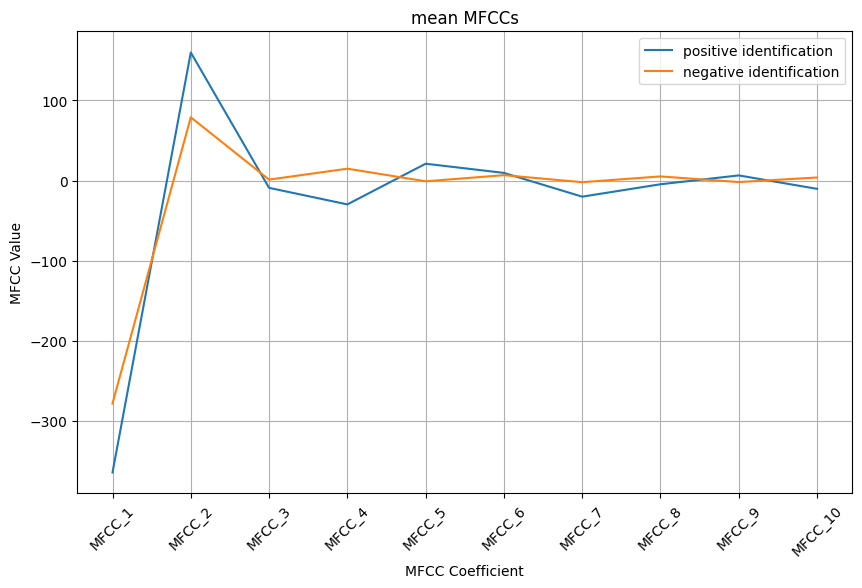

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(positive_demo_mfccs.drop(columns=['classification', 'filename']).columns, mean_demo_positive, label='positive identification')
plt.plot(positive_demo_mfccs.drop(columns=['classification', 'filename']).columns, mean_demo_negative, label='negative identification')
plt.xlabel('MFCC Coefficient')
plt.ylabel('MFCC Value')
plt.title(f"mean MFCCs")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

## Fitting SVM

In [7]:
from sklearn import svm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib

In [27]:
import numpy as np
from matplotlib.colors import Normalize


class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

### Live set

In [8]:
detection_dataset = pd.read_csv('live_detections_mfccs.csv')
detection_dataset.head()
X = detection_dataset[[f"MFCC_{i}" for i in range(1,11)]]
y = np.where(detection_dataset['classification'] == "negative", "negative", "positive")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
# clf = svm.SVC(kernel='rbf')
clf = svm.SVC(C=100.0, gamma=1e-5)
# clf = svm.NuSVC(gamma="auto")
#Train the model using the training sets
clf.fit(X_train.values, y_train)

#Predict the response for test dataset
# y_pred = clf.predict(X_test)

SVC(C=100.0, gamma=1e-05)

In [58]:
joblib.dump(clf, 'live_svm.pkl') 

['live_svm.pkl']

### Demo set

In [9]:
detection_dataset = pd.read_csv('proper_detections_mfccs.csv')
detection_dataset.head()
X = detection_dataset[[f"MFCC_{i}" for i in range(1,11)]]
y = np.where(detection_dataset['classification'] == "negative", "negative", "positive")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print(X)

          MFCC_1      MFCC_2     MFCC_3     MFCC_4     MFCC_5     MFCC_6  \
0    -564.442140    8.385604  -2.276850  -4.512310  -2.347291  -1.745333   
1    -142.999680   37.181145 -56.660970   8.878623 -15.041111  11.346839   
2      42.051224   60.085186  -7.855661  26.267555  -5.396732   3.353272   
3      43.779510   57.934246  -5.346288  23.884005  -4.785521   2.999132   
4    -420.739260   95.851380  33.803690  51.674496  13.107634  26.776213   
...          ...         ...        ...        ...        ...        ...   
2412 -290.838840  103.557050 -25.441679 -34.847652   5.344827  -9.163721   
2413 -123.461240  145.011380 -49.066020 -34.363680  39.384690  13.059895   
2414 -302.416720  138.319340   4.244566 -11.636447  23.003757   3.766546   
2415 -382.500270  179.966720  -9.590901 -39.421290  17.706102  14.936426   
2416 -459.966900   42.218834   3.548519  -2.278047   9.118684   6.897577   

         MFCC_7     MFCC_8     MFCC_9    MFCC_10  
0     -1.814555  -1.086150  -1.88088

In [30]:
# from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
# from sklearn.svm import SVC

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
# param_grid = dict(gamma=gamma_range, C=C_range)
# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
# grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
# grid.fit(X, y)

# print(
#     "The best parameters are %s with a score of %0.2f"
#     % (grid.best_params_, grid.best_score_)
# )

In [32]:
import joblib

grid = joblib.load('svm_CV.pkl')

In [33]:
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

In [ ]:
# from sklearn.externals import joblib
# joblib.dump(clf, 'svm_CV.pkl') 


In [34]:
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 100.0, 'gamma': 1e-05} with a score of 0.97


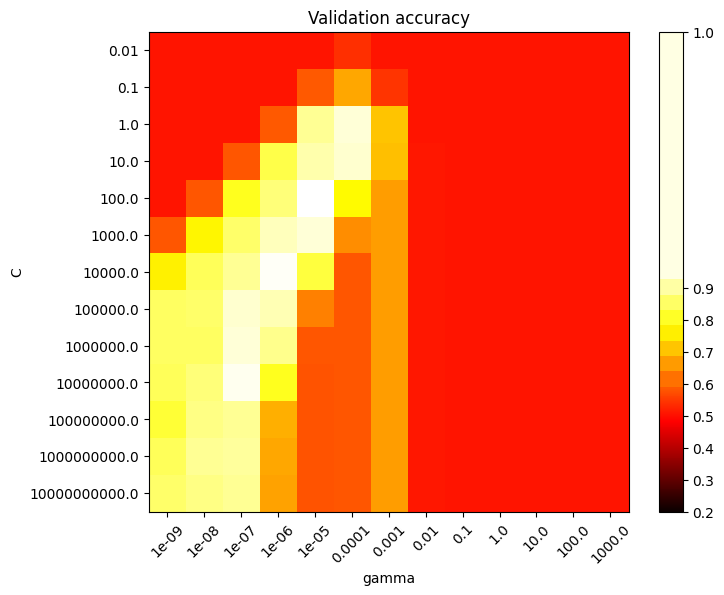

In [35]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.95),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()

### OLD

In [11]:
# clf = svm.SVC(kernel='rbf')
clf = svm.SVC(C=100.0, gamma=1e-5)
# clf = svm.NuSVC(gamma="auto")
#Train the model using the training sets
clf.fit(X_train.values, y_train)

#Predict the response for test dataset
# y_pred = clf.predict(X_test)

SVC(C=100.0, gamma=1e-05)

In [37]:
# from sklearn.externals import joblib
joblib.dump(clf, 'svm.pkl') 

['svm.pkl']

In [12]:
%%time
y_pred = clf.predict(X_test.values)

CPU times: user 8.83 ms, sys: 141 µs, total: 8.98 ms
Wall time: 8.5 ms


In [14]:
print(len(X_test)) #8.5ms / 484 = .017 ms per set of coeff

484


In [39]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9855371900826446
Classification Report:
               precision    recall  f1-score   support

    negative       0.99      0.99      0.99       402
    positive       0.96      0.95      0.96        82

    accuracy                           0.99       484
   macro avg       0.98      0.97      0.97       484
weighted avg       0.99      0.99      0.99       484



## SVM on 2 features for visualization

In [40]:
X = detection_dataset[[f"MFCC_{i}" for i in range(1,3)]]
y = np.where(detection_dataset['classification'] == "negative", "negative", "positive")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
print(X)

          MFCC_1      MFCC_2
0    -564.442140    8.385604
1    -142.999680   37.181145
2      42.051224   60.085186
3      43.779510   57.934246
4    -420.739260   95.851380
...          ...         ...
2412 -290.838840  103.557050
2413 -123.461240  145.011380
2414 -302.416720  138.319340
2415 -382.500270  179.966720
2416 -459.966900   42.218834

[2417 rows x 2 columns]


### Find best hyperparams for 2D

In [ ]:
# C_2d_range = [1e-2, 1, 1e2]
# gamma_2d_range = [1e-1, 1, 1e1]
# classifiers = []
# for C in C_2d_range:
#     for gamma in gamma_2d_range:
#         clf = SVC(C=C, gamma=gamma)
#         clf.fit(X_2d, y_2d)
#         classifiers.append((C, gamma, clf))

### Show best 2d Decsision boundary

In [42]:
model_2mfcc = svm.SVC(C=100.0, gamma=1e-5)
model_2mfcc.fit(X, y)

SVC(C=100.0, gamma=1e-05)

In [44]:
%%time
y_pred = model_2mfcc.predict(X_test.values)

CPU times: user 23.5 ms, sys: 2.63 ms, total: 26.2 ms
Wall time: 165 ms


/home/infasafe/infasafe/.testvenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [45]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8987603305785123
Classification Report:
               precision    recall  f1-score   support

    negative       0.94      0.94      0.94       402
    positive       0.70      0.71      0.70        82

    accuracy                           0.90       484
   macro avg       0.82      0.82      0.82       484
weighted avg       0.90      0.90      0.90       484



/home/infasafe/infasafe/.testvenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


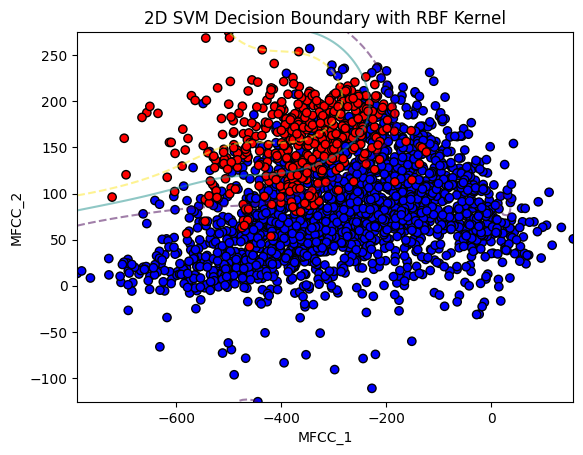

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm


# Fit the model
# model = svm.SVC(kernel='rbf')
# model.fit(X, y)

# Create grid to plot decision boundary
xx, yy = np.meshgrid(np.linspace(X['MFCC_1'].min(), X['MFCC_1'].max(), 100),
                     np.linspace(X['MFCC_2'].min(), X['MFCC_2'].max(), 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict decision function on the grid
Z = model_2mfcc.decision_function(grid).reshape(xx.shape)

# Plot decision boundary and margins
plt.contour(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# Scatter plot of the data points
plt.scatter(X['MFCC_1'], X['MFCC_2'], c=np.where(y == "negative", -1, 1)
            , cmap=plt.cm.bwr, edgecolors='k')

# Labeling
plt.xlabel('MFCC_1')
plt.ylabel('MFCC_2')
plt.title('2D SVM Decision Boundary with RBF Kernel')

plt.show()


In [47]:
def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(X['MFCC_1'].min(), X['MFCC_1'].max(), 100),
                         np.linspace(X['MFCC_2'].min(), X['MFCC_2'].max(), 100))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.seismic)
    axis.scatter(
        X['MFCC_1'],
        X['MFCC_2'],
        c=np.where(y == "negative", -1, 1),
        s=100 * sample_weight,
        alpha=0.9,
        cmap=plt.cm.bwr,
        edgecolors="black",
    )
    axis.set_xlabel('MFCC_1')
    axis.set_ylabel('MFCC_2')
    axis.axis("on")
    axis.set_title(title)

/home/infasafe/infasafe/.testvenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


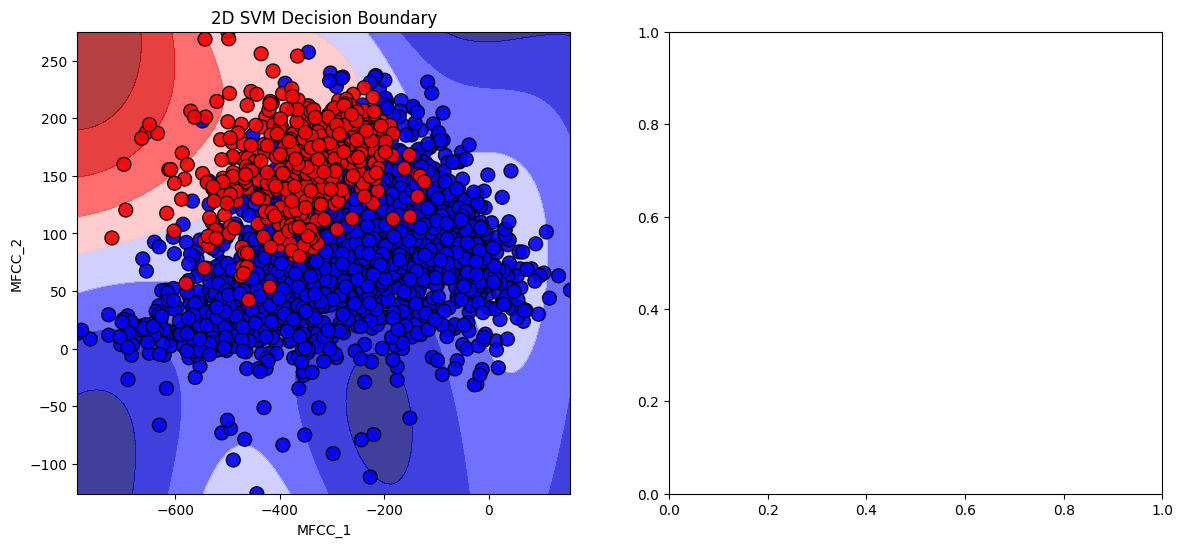

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sample_weight_constant = np.ones(len(X))
plot_decision_function(
    model_2mfcc, sample_weight_constant, axes[0], "2D SVM Decision Boundary"
)
plt.show()

# Cry Classification

In [3]:
cry_data_path = "./data/donateacry_cleaned"
cry_categories = os.listdir(cry_data_path)
cry_categories = [cat for cat in cry_categories if cat != 'README.md']

In [4]:
cry_audio_files = np.array([f"{cry_data_path}/{category}/{fname}" for category in cry_categories for fname in os.listdir(cry_data_path + "/" + category)]) 

In [5]:
cries_list = np.array([[fname,category] for category in cry_categories for fname in os.listdir(cry_data_path + "/" + category)]) 
cries = pd.DataFrame(cries_list, columns = ['filename', 'classification'])

In [6]:
n_mfcc = 10

mfcc_vectors = []

# Extract MFCC vectors for each audio file and store them in the list
for audio_file_path in cry_audio_files:
    mfcc_vector = extract_mfccs_proper(audio_file_path)
    mfcc_vectors.append(mfcc_vector)

classification_mfccs = pd.DataFrame(data=mfcc_vectors, columns=[f'MFCC_{i}' for i in range(1, n_mfcc + 1)])

demo_classification_set = pd.concat([cries.reset_index(drop=True)
                                ,classification_mfccs],axis=1)[:120]

NameError: name 'extract_mfccs_proper' is not defined

In [53]:
X = demo_classification_set[[f"MFCC_{i}" for i in range(1,11)]] # Replace 'TargetColumnName' with the actual name of your target column
y = demo_classification_set['classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Show average mfccs for each type of cry

In [54]:
category_means = {}
for category in cry_categories:
    category_mfccs = demo_classification_set.loc[demo_classification_set['classification'] == category].reset_index(drop=True)
    category_mean = [category_mfccs[mfcc].mean() for mfcc 
                      in category_mfccs.drop(columns=['classification', 'filename'])]
    category_means[category] = category_mean
print(category_means)

{'discomfort': [-363.35062, 170.84203, -3.6460423, -28.36625, 20.520638, 9.453795, -20.498428, -5.4587817, 6.069604, -9.0821085], 'tired': [-393.56665, 162.10712, -13.419112, -32.613667, 22.687431, 10.423946, -20.670416, -4.240667, 7.1706233, -11.075442], 'belly_pain': [-390.5486, 170.0541, -18.72982, -35.42102, 25.908783, 9.976913, -25.09364, -6.4507275, 5.7753634, -13.735741], 'burping': [-290.91766, 159.44623, -28.651491, -40.311035, 25.47574, 12.380234, -23.424242, -4.241699, 8.693228, -10.672987], 'hungry': [-363.31006, 169.73091, -10.881859, -30.610552, 25.026915, 10.629726, -22.501318, -4.883745, 7.8351703, -10.40182]}


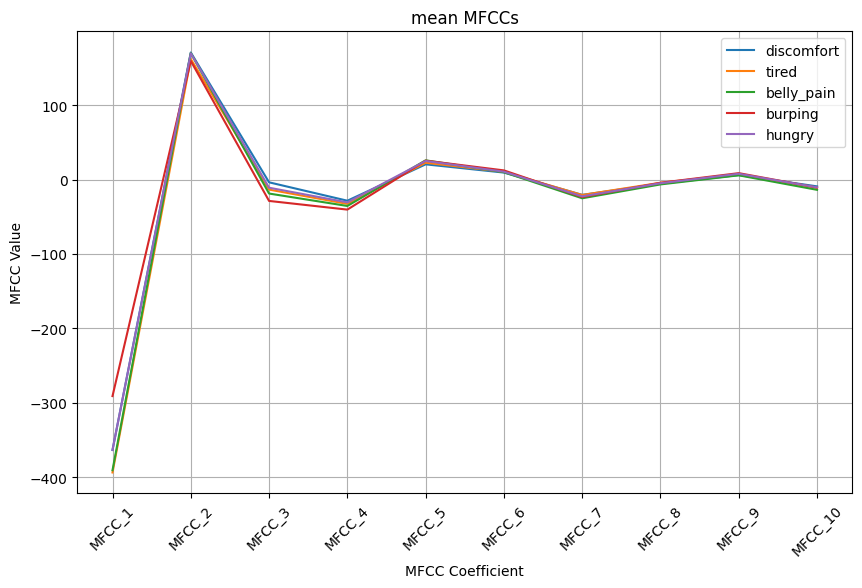

In [55]:
plt.figure(figsize=(10, 6))
for category, mean in category_means.items():
    plt.plot([f'MFCC_{i}' for i in range(1, n_mfcc + 1)], mean, label=category)
# plt.plot(positive_demo_mfccs.drop(columns=['classification', 'filename']).columns, mean_demo_positive, label='positive identification')
plt.xlabel('MFCC Coefficient')
plt.ylabel('MFCC Value')
plt.title(f"mean MFCCs")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

## Training

### Live

In [59]:
n_mfcc = 10

mfcc_vectors = []

# Extract MFCC vectors for each audio file and store them in the list
for audio_file_path in cry_audio_files:
    mfcc_vector = extract_mfccs(audio_file_path)
    mfcc_vectors.append(mfcc_vector)

classification_mfccs = pd.DataFrame(data=mfcc_vectors, columns=[f'MFCC_{i}' for i in range(1, n_mfcc + 1)])

live_classification_set = pd.concat([cries.reset_index(drop=True)
                                ,classification_mfccs],axis=1)[:120]

In [60]:
X = live_classification_set[[f"MFCC_{i}" for i in range(1,11)]] # Replace 'TargetColumnName' with the actual name of your target column
y = live_classification_set['classification']

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.1, random_state=42)

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

#create new a knn model
knn2 = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

#fit model to data
knn_gscv.fit(X.values, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [62]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set
y_pred = knn_gscv.predict(X_test)  # X_test: feature vectors of the test data

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

  belly_pain       0.50      0.33      0.40         3
     burping       1.00      1.00      1.00         1
  discomfort       0.75      0.75      0.75         4
      hungry       0.50      1.00      0.67         1
       tired       0.67      0.67      0.67         3

    accuracy                           0.67        12
   macro avg       0.68      0.75      0.70        12
weighted avg       0.67      0.67      0.66        12



In [63]:
joblib.dump(knn_gscv, 'live_knn.pkl') 

['live_knn.pkl']

In [ ]:
### Demo

In [8]:
n_mfcc = 10

mfcc_vectors = []

# Extract MFCC vectors for each audio file and store them in the list
for audio_file_path in cry_audio_files:
    mfcc_vector = extract_mfccs(audio_file_path)
    mfcc_vectors.append(mfcc_vector)

classification_mfccs = pd.DataFrame(data=mfcc_vectors, columns=[f'MFCC_{i}' for i in range(1, n_mfcc + 1)])

demo_classification_set = pd.concat([cries.reset_index(drop=True)
                                ,classification_mfccs],axis=1)[:120]

In [9]:
X = demo_classification_set[[f"MFCC_{i}" for i in range(1,11)]] # Replace 'TargetColumnName' with the actual name of your target column
y = demo_classification_set['classification']

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.1, random_state=42)

NameError: name 'train_test_split' is not defined

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

#create new a knn model
knn2 = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

#fit model to data
knn_gscv.fit(X.values, y)

In [57]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set
y_pred = knn_gscv.predict(X_test)  # X_test: feature vectors of the test data

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.4166666666666667
Classification Report:
               precision    recall  f1-score   support

  belly_pain       1.00      0.33      0.50         3
     burping       0.00      0.00      0.00         1
  discomfort       0.75      0.75      0.75         4
      hungry       0.14      1.00      0.25         1
       tired       0.00      0.00      0.00         3

    accuracy                           0.42        12
   macro avg       0.38      0.42      0.30        12
weighted avg       0.51      0.42      0.40        12



/home/infasafe/infasafe/.testvenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/infasafe/infasafe/.testvenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/infasafe/infasafe/.testvenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [58]:
# from sklearn.externals import joblib
joblib.dump(knn_gscv, 'knn.pkl') 

['knn.pkl']

# Demo

In [59]:
from sklearn import svm
import librosa
import pandas as pd
import numpy as np
import os
import wave
from audio_handler import DemoAudioHandler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

In [58]:
live_detection_set = pd.read_csv('live_detections_mfccs.csv')

In [59]:
live_detection_set.head()

,filename,classification,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10
0,1-100032-A-0.wav,negative,439.98962,8.207122,-6.658803,-4.290906,-3.034478,0.259279,-1.963947,-0.271577,0.518284,0.341884
1,1-100038-A-14.wav,negative,766.79333,85.839620,-107.103160,31.011578,-39.987736,-17.290340,-37.214104,-18.145689,-11.705071,-17.621454
2,1-100210-A-36.wav,negative,991.26850,102.503900,-40.419437,39.016900,-22.449158,12.773843,-8.455192,20.697040,-11.590557,18.945305
3,1-100210-B-36.wav,negative,990.61536,104.300380,-43.018017,42.277380,-26.241453,18.346586,-10.591763,22.344328,-12.172708,16.495598
4,1-101296-A-19.wav,negative,555.10754,144.261400,22.961348,52.213543,2.970680,11.319603,-2.895933,0.076407,-8.929121,10.019115


In [60]:
X = live_detection_set[[f"MFCC_{i}" for i in range(1,11)]]
y = np.where(live_detection_set['classification'] == "negative", "negative", "positive")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
print(X.values)

[[ 4.3998962e+02  8.2071220e+00 -6.6588025e+00 ... -2.7157682e-01
   5.1828414e-01  3.4188426e-01]
 [ 7.6679333e+02  8.5839620e+01 -1.0710316e+02 ... -1.8145689e+01
  -1.1705071e+01 -1.7621454e+01]
 [ 9.9126850e+02  1.0250390e+02 -4.0419437e+01 ...  2.0697040e+01
  -1.1590557e+01  1.8945305e+01]
 ...
 [ 6.8814150e+02  1.3973756e+02 -6.2013583e+00 ... -1.9102283e+01
  -1.2335887e+01 -2.3200170e+01]
 [ 6.1446387e+02  1.6523610e+02 -2.2854877e+01 ... -1.6890171e+01
   1.0902433e+01  4.2652080e+00]
 [ 5.1609753e+02  4.1088757e+01  2.2619107e+00 ...  2.2825458e+00
   2.9961882e+00 -3.3482609e+00]]


In [62]:
clf = svm.SVC(C=100.0, gamma=1e-5)
clf = svm.SVC(kernel = 'rbf')
clf.fit(X.values, y)

SVC()

In [63]:
y_pred = clf.predict(X_test.values)

In [64]:
joblib.dump(clf, 'live_svm.pkl') 

['live_svm.pkl']

In [ ]:
print(y_pred)

In [2]:
import pyaudio
import joblib
import numpy as np
import pyaudio
import time
import librosa
import wave
import pickle

In [3]:
class DemoAudioHandler(object):
    def __init__(self, duration, svm, knn, test_wav, debug=False, eventmonitor=None):
        self.FORMAT = pyaudio.paInt16
        self.CHANNELS = 1
        self.RATE = 8000
        self.CHUNK = 1024 * 2
        self.RECORD_SECONDS = 5
        self.DURATION = duration
        self.frame_to_proc = []
        self.audio_buffer = []
        self.n_mfcc = 10
        self.starttime = time.time()
        self.mfccs = None
        self.p = None
        self.stream = None
        self.wf = wave.open(test_wav, 'rb')
        self.i = 0
        self.indetification_stamps = []
        self.eventmonitor = eventmonitor

    def start(self):
        self.p = pyaudio.PyAudio()
        self.FORMAT = self.p.get_format_from_width(self.wf.getsampwidth())
        # print(self.FORMAT)
        self.CHANNELS = self.wf.getnchannels()
        self.RATE = self.wf.getframerate()
        # print(self.CHANNELS, self.RATE)
        self.stream = self.p.open(format=self.FORMAT,
                                  channels=self.CHANNELS,
                                  rate=self.RATE,
                                  input=True,
                                  output=False,
                                  stream_callback=self.callback,
                                  frames_per_buffer=self.CHUNK)

    def stop(self, debug=False):
        self.audio_buffer.extend(self.frame_to_proc)
        audio_data = b''.join(self.frame_to_proc)
        audio_array = np.frombuffer(audio_data, dtype=np.int16)
        self.mfccs = librosa.feature.mfcc(y=audio_array.astype('float32'), 
                                          sr=self.RATE, n_mfcc=self.n_mfcc,dtype=np.float32).mean(axis=1)
        # print('end mfccs',self.mfccs)
        prediction = svm.predict(self.mfccs.reshape(1, -1))
        print('prediction',prediction)
        if prediction == 'positive':
            cry_classification = knn.predict(self.mfccs.reshape(1, -1))
            print('cry guess', cry_classification)
            
            if self.eventmonitor:
                print('cry event')
                self.eventmonitor.set_event('cry_event')
        self.frame_to_proc = []
        self.stream.close()
        self.p.terminate()

    #TODO - increase the buffer to 5 sec
    def callback(self, in_data, frame_count, time_info, flag):
        self.frame_to_proc.append(self.wf.readframes(frame_count))
        if len(self.frame_to_proc) * self.CHUNK  >= self.RECORD_SECONDS * self.RATE:
            self.audio_buffer.extend(self.frame_to_proc)
            audio_data = b''.join(self.frame_to_proc)
            audio_array = np.frombuffer(audio_data, dtype=np.int16)
            self.mfccs = librosa.feature.mfcc(y=audio_array.astype('float32'), 
                                              sr=self.RATE, n_mfcc=10,dtype=np.float32).mean(axis=1)
            prediction = svm.predict(self.mfccs.reshape(1, -1))
            print('prediction',prediction)
            if prediction == 'positive':
                cry_classification = knn.predict(self.mfccs.reshape(1, -1))
                self.indetification_stamps.append((time.time, cry_classification))
                print('cry guess', cry_classification)
                if self.eventmonitor:
                    print('cry event')
                    self.eventmonitor.set_event('cry_event')
            self.frame_to_proc = []
        return None, pyaudio.paContinue

    def mainloop(self):
        while (self.stream.is_active() and (time.time() - self.starttime) < self.DURATION): # if using button you can set self.stream to 0 (self.stream = 0), otherwise you can use a stop condition
            time.sleep(1.0)

In [5]:
knn = joblib.load('knn.pkl')
svm = joblib.load('live_svm.pkl')

In [6]:
audio = DemoAudioHandler(60, svm, knn, './data/test/sounds.wav')
audio.start()    # open the the stream
audio.mainloop()  
audio.stop()

ALSA lib confmisc.c:1281:(snd_func_refer) Unable to find definition 'cards.tegra-hda.pcm.front.0:CARD=0'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5220:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM front
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib confmisc.c:1281:(snd_func_refer) Unable to find definition 'cards.tegra-hda.pcm.surround51.0:CARD=0'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5220:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM surround21
ALSA lib confmisc.c:1281:(snd_func_refer) Unable to

prediction ['negative'] clip mfccs [581.04785  154.91895   98.63606   36.178383  -6.582004 -18.271372
  -6.297165  11.078253  18.203793  11.269361]
prediction ['negative'] clip mfccs [ 6.2686646e+02  1.4172153e+02  8.8110909e+01  2.8240618e+01
 -1.4018627e+01 -2.7384577e+01 -1.7288670e+01  3.1887078e-01
  1.0623178e+01  8.4713354e+00]
prediction ['negative'] clip mfccs [587.78156     93.75465     67.32583     36.246452    11.448667
  -0.62109256  -0.60680795   5.577504    11.150483    12.253922  ]
prediction ['negative'] clip mfccs [503.5783    128.46114    89.47478    45.472393   13.762091    2.5599535
   7.7254686  17.699093   21.99705    17.403816 ]
prediction ['negative'] clip mfccs [666.0293    128.51138   -38.04048    46.649406  -30.72183     7.7250433
  -1.6154045  15.311115   -9.039448    2.1090324]
prediction ['negative'] clip mfccs [639.2842    135.89607    51.10055    44.490437   18.608313   13.206418
  11.771769    4.3881965   3.9229043   4.2768536]
prediction ['negative'] 

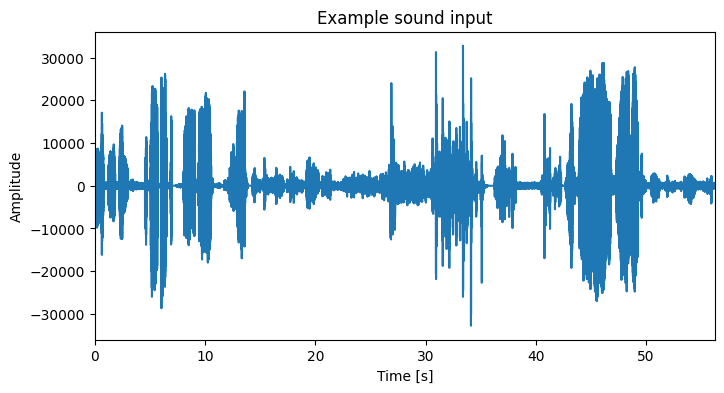

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

def plot_wav(filename, title):
    # Read the wav file
    sample_rate, data = wavfile.read(filename)
    
    # Create a time array from the number of samples
    time = np.linspace(0, len(data) / sample_rate, num=len(data))
    
    # Plot the waveform
    plt.figure(figsize=(8, 4))
    plt.plot(time, data)
    plt.title(title)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [s]")
    plt.xlim([0, time.max()])
    plt.show()

# Plot the wav file
plot_wav('./data/test/sounds.wav', 'Example sound input')


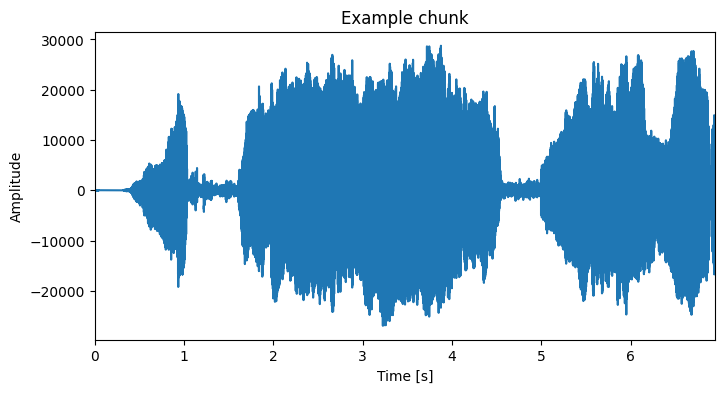

In [37]:
plot_wav('./data/test/dono/dono_cry_1.wav', 'Example chunk')


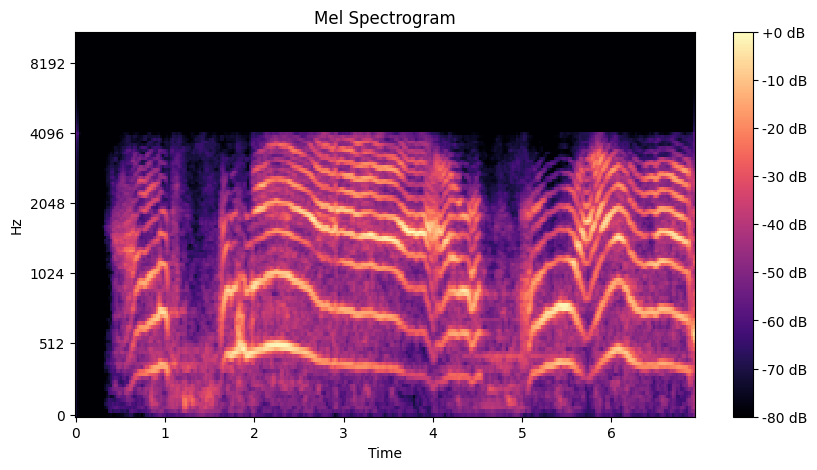

In [33]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the WAV file
file_path = './data/test/dono/dono_cry_1.wav'
y, sr = librosa.load(file_path)

# Compute the Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert power spectrogram to dB scale
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Display the Mel spectrogram
plt.figure(figsize=(10, 5))
librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()


In [33]:
def plot_decision_function_debug(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(X['MFCC_1'].min(), X['MFCC_1'].max(), 100),
                         np.linspace(X['MFCC_2'].min(), X['MFCC_2'].max(), 100))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.seismic)
    axis.scatter(
        X['MFCC_1'],
        X['MFCC_2'],
        c=np.where(y == "negative", -1, 1),
        s=100 * sample_weight,
        alpha=0.9,
        cmap=plt.cm.bwr,
        edgecolors="black",
    )
    axis.scatter(
        X_de['MFCC_1'],
        X_de['MFCC_2'],
        c='g'
    )
    axis.set_xlabel('MFCC_1')
    axis.set_ylabel('MFCC_2')
    axis.axis("on")
    axis.set_title(title)

In [16]:
detection_dataset = pd.read_csv('live_detections_mfccs.csv')
detection_dataset.head()
X = detection_dataset[[f"MFCC_{i}" for i in range(1,3)]]
y = np.where(detection_dataset['classification'] == "negative", "negative", "positive")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
live_test_set = pd.read_csv('../debug_handler_mfccs.csv')
X_de = live_test_set[[f"MFCC_{i}" for i in range(1,3)]]
# y_de = np.where(live_test_set['classification'] == "negative", "negative", "positive")

In [17]:
# clf = svm.SVC(kernel='rbf')
clf = svm.SVC(C=100.0, gamma=1e-5)
# clf = svm.NuSVC(gamma="auto")
#Train the model using the training sets
clf.fit(X_train.values, y_train)

#Predict the response for test dataset
# y_pred = clf.predict(X_test)

SVC(C=100.0, gamma=1e-05)

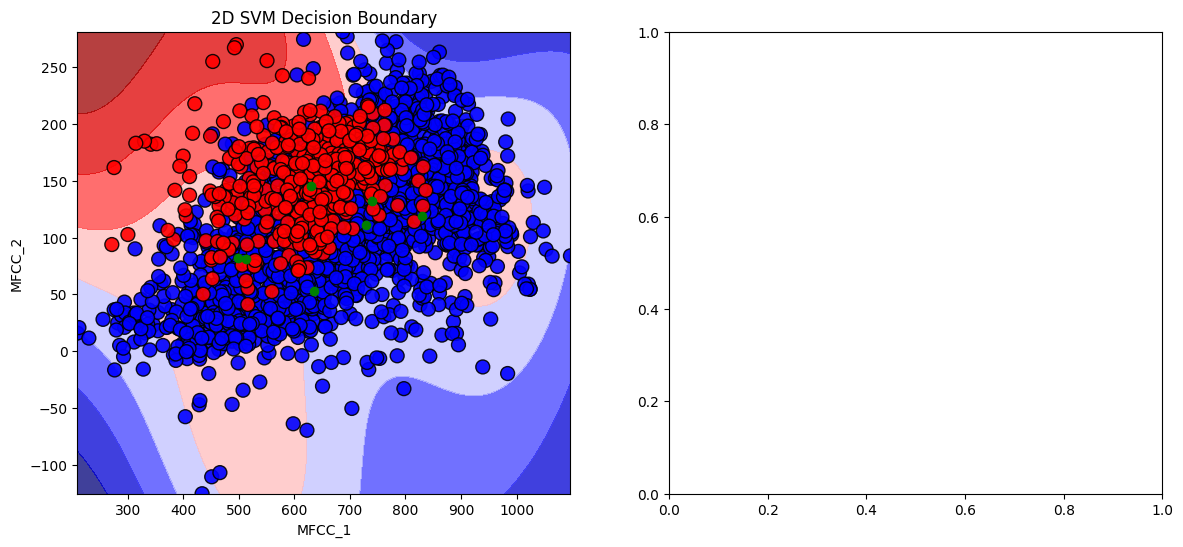

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sample_weight_constant = np.ones(len(X))
plot_decision_function_debug(
    clf, sample_weight_constant, axes[0], "2D SVM Decision Boundary"
)
plt.show()

# Train pipline for robustness

In [78]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

detection_dataset = pd.read_csv('live_detections_mfccs.csv')
X = detection_dataset[[f"MFCC_{i}" for i in range(1,3)]]
y = np.where(detection_dataset['classification'] == "negative", "negative", "positive")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipe_standard_2d = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf'))])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe_standard_2d.fit(X_train, y_train).score(X_test, y_test)

0.8367768595041323

In [79]:
pipe_min_max_2d = Pipeline([('scaler', MinMaxScaler()), ('svc', SVC(kernel='rbf'))])
pipe_min_max_2d.fit(X_train, y_train).score(X_test, y_test)

0.8388429752066116

In [80]:
pipe_weight_2d = Pipeline([('scaler', MinMaxScaler()), ('svc', SVC(kernel='rbf', class_weight ={'positive':50}))])
pipe_weight_2d.fit(X_train, y_train).score(X_test, y_test)

0.4772727272727273

/home/infasafe/infasafe/.testvenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/infasafe/infasafe/.testvenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/infasafe/infasafe/.testvenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


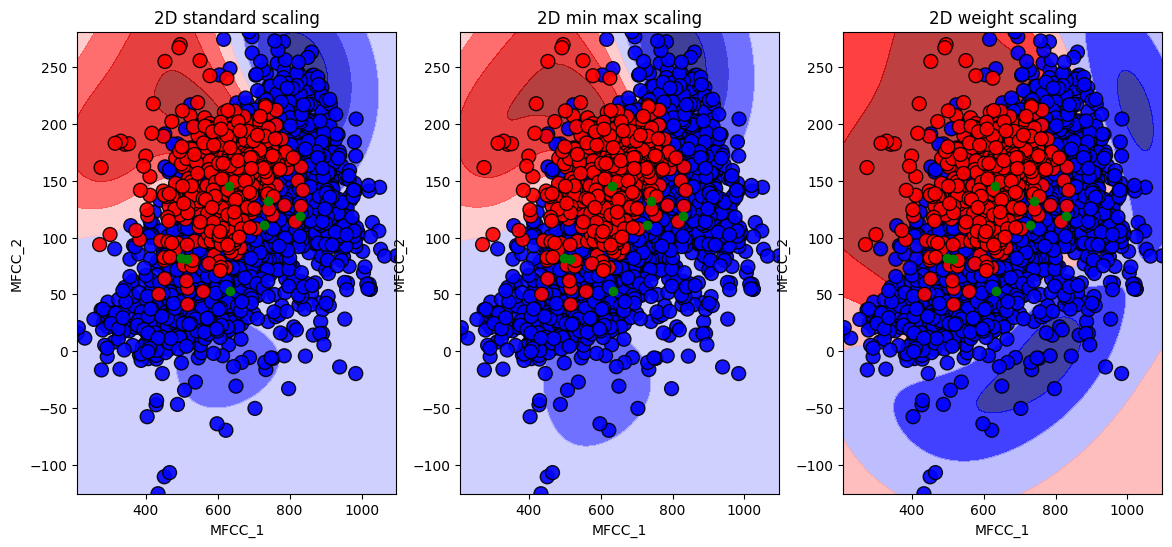

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
sample_weight_constant = np.ones(len(X))
plot_decision_function_debug(pipe_standard_2d, sample_weight_constant, axes[0], "2D standard scaling")
plot_decision_function_debug(pipe_min_max_2d, sample_weight_constant, axes[1], "2D min max scaling")
plot_decision_function_debug(pipe_weight_2d, sample_weight_constant, axes[2], "2D weight scaling")
plt.show()

In [82]:
detection_dataset = pd.read_csv('live_detections_mfccs.csv')
X = detection_dataset[[f"MFCC_{i}" for i in range(1,11)]]
y = np.where(detection_dataset['classification'] == "negative", "negative", "positive")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipe_standard = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf'))])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe_standard.fit(X_train.values, y_train).score(X_test.values, y_test)
joblib.dump(pipe_standard, 'standard_scale_svm.pkl') 

pipe_min_max = Pipeline([('scaler', MinMaxScaler()), ('svc', SVC(kernel='rbf'))])
pipe_min_max.fit(X_train.values, y_train).score(X_test.values, y_test)

joblib.dump(pipe_min_max, 'min_max_svm.pkl') 

pipe_weight = Pipeline([('scaler', MinMaxScaler()), ('svc', SVC(kernel='rbf', class_weight ={'positive':10}))])
pipe_weight.fit(X_train.values, y_train).score(X_test.values, y_test)
joblib.dump(pipe_weight, 'weight_svm.pkl') 

['weight_svm.pkl']